# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [ ]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import torch.optim as optim
from torch.nn import MSELoss
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt












# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [2]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [3]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 4200
    })
})


In [5]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
#print 
print(dataset['train'].column_names)
print (dataset['train'][0])
print (dataset['train'][:3])



['SMILES', 'label']
{'SMILES': 'Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'label': 3.54}
{'SMILES': ['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl'], 'label': [3.54, -1.18, 3.69]}


In [6]:
# Calculate the maximum length of SMILES strings in the dataset
max_length = max(len(smile) for smile in dataset['train']['SMILES'])
print(f"Max SMILES length: {max_length}")



# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
# class SMILESDataset(Dataset):


class SMILESDataset(Dataset):
    def __init__(self, smiles, labels, tokenizer, max_length=300):  # Set max_length to 300
        self.smiles = smiles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            smile, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_length, 
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

Max SMILES length: 267


## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [7]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [8]:
# split the data into training and test datasets
# TODO: your code goes here

# Extract SMILES and labels from the dataset
smiles = dataset['train']['SMILES']
labels = dataset['train']['label']

# Split the dataset into training and testing sets
train_smiles, test_smiles, train_labels, test_labels = train_test_split(
    smiles, labels, test_size=0.2, random_state=42
)

# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Create training and testing datasets
train_dataset = SMILESDataset(train_smiles, train_labels, tokenizer, max_length=300)
test_dataset = SMILESDataset(test_smiles, test_labels, tokenizer, max_length=300)

In [9]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# TODO: your code goes here

## --- Step 3: Load Model ---

In [10]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

In [11]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

#class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here 


class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model, hidden_size, dropout_prob=0.1):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model  # Pre-trained MoLFormer model
        self.dropout = nn.Dropout(dropout_prob)  # Dropout for regularization
        self.regression_head = nn.Linear(hidden_size, 1)  # Regression head

    def forward(self, input_ids, attention_mask):
        # Get hidden states from the pre-trained model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the [CLS] token's hidden state for regression
        cls_hidden_state = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
        
        # Apply dropout and regression head
        cls_hidden_state = self.dropout(cls_hidden_state)
        logits = self.regression_head(cls_hidden_state)  # Shape: (batch_size, 1)
        
        return logits.squeeze()  # Remove extra dimension for regression output  
    

# Get the hidden size from the pre-trained model and initialize the regression model accordingly
# if we have 1024 hidden size, we will have 1024 input features for the regression head and 1 output feature for the regression output
# hidden_size = model.config.hidden_size  # this
hidden_size = model.config.hidden_size  # this 


In [12]:
# initialize the regression model



# Initialize the regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model, hidden_size).to(device)


# Print the device to verify
print(f"Model is loaded on: {device}")

Model is loaded on: cuda


In [13]:
print (model)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

In [14]:
regression_model

MoLFormerWithRegressionHead(
  (model): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

## --- Step 4: Training ---

In [15]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [16]:
# TODO: your code goes here





# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define loss function and optimizer
criterion = MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(regression_model.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Training loop
num_epochs = 7
best_loss = float('inf')  # Initialize best loss to a large value

for epoch in range(num_epochs):
    regression_model.train()  # Set model to training mode
    epoch_loss = 0.0

    # Progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = regression_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({"Training Loss": loss.item()})

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Save the best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save(regression_model.state_dict(), "best_regression_model.pth")
        print(f"New best model saved with loss: {best_loss:.4f}")

print("Training complete!")




Epoch 1/7, Average Loss: 1.0139
New best model saved with loss: 1.0139


Epoch 2/7, Average Loss: 0.5381
New best model saved with loss: 0.5381


Epoch 3/7, Average Loss: 0.3881
New best model saved with loss: 0.3881


KeyboardInterrupt: 

In [18]:
import os

# Define the path to save the model
save_dir = r"C:\Users\ishek\Downloads\Project_Files (2)\notebooks"
model_save_path = os.path.join(save_dir, "regression_model.pth")

# Save the model
torch.save(regression_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:\Users\ishek\Downloads\Project_Files (2)\notebooks\regression_model.pth


In [19]:
# Define the path to load the model
load_dir = r"C:\Users\ishek\Downloads\Project_Files (2)\notebooks"
model_load_path = os.path.join(load_dir, "regression_model.pth")

# Initialize the model architecture
hidden_size = model.config.hidden_size
regression_model = MoLFormerWithRegressionHead(model, hidden_size).to(device)

# Load the saved model weights
regression_model.load_state_dict(torch.load(model_load_path))
regression_model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_load_path} and ready for evaluation.")

Model loaded from C:\Users\ishek\Downloads\Project_Files (2)\notebooks\regression_model.pth and ready for evaluation.


## --- Step 5: Evaluation ---

In [20]:


def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")



    

    return true_labels, predictions  # Ensure this line is present

In [21]:
import numpy as np
# Evaluate the model and get predictions
true_labels, predictions = evaluate_model(regression_model, test_loader, device)

# Save predictions and true labels to a CSV file
results = pd.DataFrame({
    "True Labels": true_labels,
    "Predictions": predictions
})
results.to_csv("evaluation_results_supervised.csv", index=False)
print("Evaluation results saved to evaluation_results.csv")

Evaluating: 100%|██████████| 53/53 [00:22<00:00,  2.37it/s]

Mean Squared Error (MSE): 0.5198
Mean Absolute Error (MAE): 0.5499
R^2 Score: 0.6482
Evaluation results saved to evaluation_results.csv


# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [27]:
# Fine-tuning the MoLFormer model using Masked Language Modeling (MLM)


# Function to tokenize dataset
def tokenize_function(examples):
    return tokenizer(
        examples["SMILES"],
        padding="max_length",
        truncation=True,
        max_length=300,
        return_attention_mask=True
    )

# Tokenize and format dataset
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["SMILES", "label"]  # Remove unnecessary columns
)

tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Define Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# DataLoader
BATCH_SIZE = 16
train_dataset = tokenized_datasets["train"]
mlm_train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator
)

# Load Pretrained Model
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True)
mlm_model.to(device)

# Define Optimizer
optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=5e-5)

# Training Loop
num_epochs = 7 # Increase for better fine-tuning
best_loss = float('inf')  # Track the best loss

for epoch in range(num_epochs):
    mlm_model.train()
    running_loss = 0.0

    for batch in tqdm(mlm_train_loader, desc=f"MLM Fine-tuning Epoch {epoch+1}/{num_epochs}"):
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        labels = batch.get("labels")
        if labels is not None:
            labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlm_model(
            input_ids=inputs,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(mlm_model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(mlm_train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        mlm_model.save_pretrained("fine_tuned_molformer_mlm")  # Save the best model
        tokenizer.save_pretrained("fine_tuned_molformer_mlm")  # Save the tokenizer
        print(f"New best model saved with loss: {best_loss:.4f}")

print("Fine-tuned model saved successfully!")



MLM Fine-tuning Epoch 1/7:   3%|▎         | 9/263 [03:47<1:47:13, 25.33s/it]


KeyboardInterrupt: 

# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [22]:
# TODO: your code goes here

# Load the fine-tuned MLM model
mlm_finetuned_model = AutoModel.from_pretrained("fine_tuned_molformer_mlm", trust_remote_code=True)


In [ ]:
# TODO: your code goes here

# Load the fine-tuned MLM model
mlm_finetuned_model = AutoModel.from_pretrained("fine_tuned_molformer_mlm", trust_remote_code=True)

# Attach Regression Head
regression_model_mlm = MoLFormerWithRegressionHead(
    model=mlm_finetuned_model,
    hidden_size=mlm_finetuned_model.config.hidden_size
).to(device)

# Define Loss and Optimizer
criterion = MSELoss()
optimizer = optim.Adam(regression_model_mlm.parameters(), lr=1e-4)

# Training Loop
num_epochs = 7  # Adjust if needed
best_loss = float('inf')  # Initialize best loss to a large value

for epoch in range(num_epochs):
    regression_model_mlm.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Fine-Tuning Regression (MLM) Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = regression_model_mlm(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"Training Loss": loss.item()})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Save the best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save(regression_model_mlm.state_dict(), "best_regression_model_mlm.pth")
        print(f"New best model saved with loss: {best_loss:.4f}")

print("Fine-Tuning Complete!")

Epoch 1/7, Average Loss: 0.9477
New best model saved with loss: 0.9477


Epoch 2/7, Average Loss: 0.5294
New best model saved with loss: 0.5294


Epoch 3/7, Average Loss: 0.3932
New best model saved with loss: 0.3932


Epoch 4/7, Average Loss: 0.3189
New best model saved with loss: 0.3189


Epoch 5/7, Average Loss: 0.2770
New best model saved with loss: 0.2770


Epoch 6/7, Average Loss: 0.2416
New best model saved with loss: 0.2416


Epoch 7/7, Average Loss: 0.2045
New best model saved with loss: 0.2045
Fine-Tuning Complete!


In [ ]:


# Load the fine-tuned MLM model
mlm_finetuned_model = AutoModel.from_pretrained("fine_tuned_molformer_mlm", trust_remote_code=True)

# Attach Regression Head
regression_model_mlm = MoLFormerWithRegressionHead(
    model=mlm_finetuned_model,
    hidden_size=mlm_finetuned_model.config.hidden_size
).to(device)

# Load saved weights
regression_model_mlm.load_state_dict(torch.load("best_regression_model_mlm.pth", map_location=device))

# Set model to evaluation mode
regression_model_mlm.eval()

print("Model successfully loaded and ready for evaluation!")


Model successfully loaded and ready for evaluation!


In [32]:
#   Evaluate the fine-tuned model



def evaluate_regression_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())  # Store actual labels

    # Convert lists to NumPy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate evaluation metrics
    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    return mse, mae, r2

# Evaluate the original regression model
mse_before, mae_before, r2_before = evaluate_regression_model(regression_model, test_loader, device)
print(f"Original Model - MSE: {mse_before:.4f}, MAE: {mae_before:.4f}, R²: {r2_before:.4f}")

# Evaluate the regression model fine-tuned after MLM
mse_after, mae_after, r2_after = evaluate_regression_model(regression_model_mlm, test_loader, device)
print(f"MLM Fine-Tuned Model - MSE: {mse_after:.4f}, MAE: {mae_after:.4f}, R²: {r2_after:.4f}")


Original Model - MSE: 0.5198, MAE: 0.5499, R²: 0.6482
MLM Fine-Tuned Model - MSE: 0.4549, MAE: 0.5145, R²: 0.6921


In [ ]:

def evaluate_regression_model(model, dataloader, device, return_predictions=False):
    """
    Evaluates a regression model and returns performance metrics.
    
    Args:
        model: The regression model to evaluate.
        dataloader: DataLoader for evaluation.
        device: The device (CPU or GPU).
        return_predictions: If True, returns predicted values along with metrics.

    Returns:
        mse, mae, r2 (and predictions, true labels if return_predictions=True)
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())  # Store actual labels

    # Convert lists to NumPy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate evaluation metrics
    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    if return_predictions:
        return mse, mae, r2, predictions, true_labels
    else:
        return mse, mae, r2

# Evaluate the original regression model (with predictions for visualization)
mse_before, mae_before, r2_before, predictions_original, true_values = evaluate_regression_model(
    regression_model, test_loader, device, return_predictions=True
)

# Evaluate the fine-tuned model (with predictions)
mse_after, mae_after, r2_after, predictions_finetuned, _ = evaluate_regression_model(
    regression_model_mlm, test_loader, device, return_predictions=True
)

# Print results
print(f"Original Model - MSE: {mse_before:.4f}, MAE: {mae_before:.4f}, R²: {r2_before:.4f}")
print(f"MLM Fine-Tuned Model - MSE: {mse_after:.4f}, MAE: {mae_after:.4f}, R²: {r2_after:.4f}")


Original Model - MSE: 0.5198, MAE: 0.5499, R²: 0.6482
MLM Fine-Tuned Model - MSE: 0.4370, MAE: 0.4985, R²: 0.7042


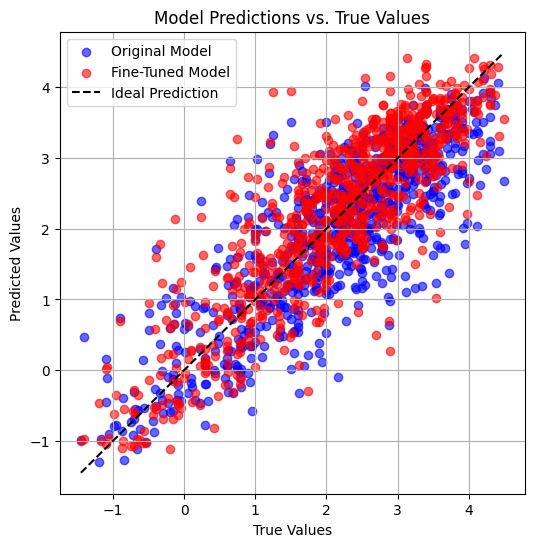

In [ ]:


# Compute predictions for both models
true_values = np.array(true_labels)  # Actual values
pred_original = np.array(predictions_original)  # Original model predictions
pred_finetuned = np.array(predictions_finetuned)  # Fine-tuned model predictions

# Create scatter plots
plt.figure(figsize=(6, 6))
plt.scatter(true_values, pred_original, alpha=0.6, label="Original Model", color="blue")
plt.scatter(true_values, pred_finetuned, alpha=0.6, label="Fine-Tuned Model", color="red")

# Plot y = x line (perfect predictions)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', label="Ideal Prediction")

# Labels and legend
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs. True Values")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
